### 1. Download pretrained model and export to ONNX

# 1.1 Load model

In [1]:
from torchvision import models, datasets, transforms as T
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 58.9MB/s]


# 1.2 Export model to ONNX

In [2]:
%%capture
!pip install onnx
!pip install onnxruntime

In [3]:
import torch
image_height = 224
image_width = 224
x = torch.randn(1, 3, image_height, image_width, requires_grad = True)
torch_out = mobilenet_v2(x)

# export
torch.onnx.export(mobilenet_v2,
                  x,
                  "mobilenet_v2.onnx",
                  export_params=True, # luu trong so mo hinh
                  opset_version=12, # version cua model
                  do_constant_folding=True, # thuc hien lien tuc de toi ui hoa
                  input_names = ['input'],
                  output_names = ['output']
                  )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# 1.3 chay thu voi mau

In [6]:
from PIL import Image
import numpy as np
import onnxruntime
import torch

def preprocess_image(image_path, height, width, channels = 3):
    image = Image.open(image_path)
    image = image.resize((width, height), Image.ANTIALIAS)
    image_data = np.asarray(image).astype(np.float32)
    image_data = image_data.transpose([2, 0, 1]) 
    mean = np.array([0.079, 0.005, 0]) + 0.406
    std = np.array([0.005, 0, 0.001]) + 0.224
    for channel in range(image_data.shape[0]):
        image_data[channel,:,:] = (image_data[channel, :, :]/255 - mean[channel]) / std[channel]

    image_data = np.expand_dims(image_data, 0)
    return image_data

# Load label

In [9]:
# Download ImageNet labels
!curl -o imagenet_classes.txt https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10472  100 10472    0     0  54827      0 --:--:-- --:--:-- --:--:-- 54827


# chay tren ONNXRuntime

label:  tabby


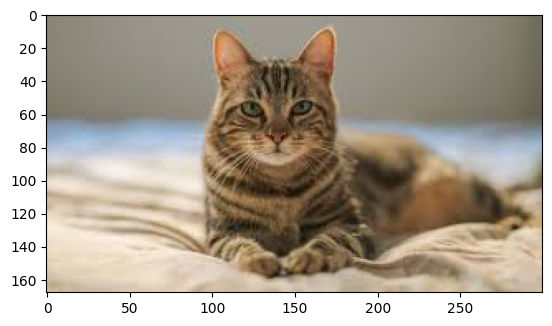

In [15]:
import matplotlib.pyplot as plt

session_fp32 = onnxruntime.InferenceSession('mobilenet_v2.onnx')

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def run_sample(session, image_file, categories):
    output= session.run([], {'input': preprocess_image(image_file, image_height, image_width)})[0]
    output = output.flatten()
    output = softmax(output)
    top_catid = np.argsort(-output)[0]
    
    # print(categories[top_catid], output[top_catid])
    return top_catid, output[top_catid]

id, acc = run_sample(session_fp32, '/content/calibration_imagenet/cat.jpg', categories)
print('label: ', categories[id])
img = Image.open('/content/calibration_imagenet/cat.jpg')
plt.imshow(img)

### 2. Quantize model

# 2.1 trien khai voi CalibratonDataReader
- lay du lieu hieu chuan va dao tao dau vao cho mo hinh

In [4]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType
import os

def preprocess_func(image_folder, height, width, size_limit=0):
    image_names = os.listdir(image_folder)
    if size_limit > 0 and len(image_names) >= size_limit:
        batch_filenames = [image_names[i] for i in range(size_limit)]
    else:
        batch_filenames = image_names
    unconcatenated_batch_data = []

    for image_name in batch_filenames:
        image_filepath = image_folder + '/' + image_name
        image_data = preprocess_image(image_filepath, height, width)
        unconcatenated_batch_data.append(image_data)
    batch_data = np.concatenate(np.expand_dims(unconcatenated_batch_data, axis =0), axis=0)
    return batch_data

class MobilenetDataReader(CalibrationDataReader):
    def __init__(self, calibration_image_folder):
        self.image_folder = calibration_image_folder
        self.preprocess_flag = True
        self.enum_data_dicts = []
        self.datasize = 0

    def get_next(self):
        if self.preprocess_flag:
            self.preprocess_flag = False
            nhwc_data_list = preprocess_func(self.image_folder, image_height, image_width, size_limit=0)
            self.datasize = len(nhwc_data_list)
            self.enum_data_dicts = iter([{'input': nhwc_data} for nhwc_data in nhwc_data_list])
        return next(self.enum_data_dicts, None)

# 2.2 Quantize model

In [7]:
calibration_data_folder = 'calibration_imagenet'
dr = MobilenetDataReader(calibration_data_folder)

quantize_static('mobilenet_v2.onnx',
                'mobilenet_v2_uint8.onnx', 
                dr)

print('ONNX full precisin model size (MB): ', os.path.getsize('mobilenet_v2.onnx')/(1024*1024))
print('ONNX quantized model size (MB):', os.path.getsize('mobilenet_v2_uint8.onnx')/(1024*1024))

ONNX full precisin model size (MB):  13.344059944152832
ONNX quantized model size (MB): 3.4839887619018555


# 2.3 Run the model 

In [11]:
session_quant = onnxruntime.InferenceSession('mobilenet_v2_uint8.onnx')
run_sample(session_quant, '/content/calibration_imagenet/cat.jpg', categories)

tabby 0.6859737


(281, 0.6859737)

### 3. so sanh toc do va acc


In [12]:
def infer_mobilenet_v2(image_path):
    img = preprocess_image(image_path, 224,224)
    img = torch.from_numpy(img)
    mobilenet_v2.eval()
    with torch.inference_mode():
        pred = mobilenet_v2(img)
        label_pred = torch.argmax(torch.softmax(pred, dim=1), dim=1)
    
        return label_pred


In [18]:
N_warmup_run = 50
N_run = 1000
quant_time = []
infer_true = 0
acc_quant = 0
import time

for i in range(N_warmup_run):
    image_path = '/content/folder_image/anh_%d.jpg' % (i%2)
    id = run_sample(session_quant, image_path, categories)

for i in range(N_run):
    image_path = '/content/folder_image/anh_%d.jpg' % (i%2)
    id_org = infer_mobilenet_v2(image_path)
    start_time = time.time()
    id, acc = run_sample(session_quant, image_path, categories)
    end_time = time.time()
    quant_time = np.append(quant_time, end_time-start_time)
    acc_quant = acc_quant + acc
    if id_org == id:
        infer_true = infer_true + 1

print('time of infer quanti {:4.1f}ms'.format(quant_time.mean() * 1000))
print('percent correct of quanti: ', infer_true/10)
print('acc of quant: ', acc_quant/1000)

time of infer quanti 20.4ms
percent correct of quanti:  100.0
acc of quant:  0.802353024482727


In [17]:
N_warmup_run = 50
N_run = 1000
fp32_time = []
infer_true = 0
acc_fp32 = 0
import time

for i in range(N_warmup_run):
    image_path = '/content/folder_image/anh_%d.jpg' % (i%2)
    id = run_sample(session_fp32, image_path, categories)

for i in range(N_run):
    image_path = '/content/folder_image/anh_%d.jpg' % (i%2)
    id_org = infer_mobilenet_v2(image_path)
    start_time = time.time()
    id, acc = run_sample(session_fp32, image_path, categories)
    end_time = time.time()
    acc_fp32 = acc_fp32 + acc
    fp32_time = np.append(fp32_time, end_time-start_time)

    if id_org == id:
        infer_true = infer_true + 1

print('time of infer fp32 {:4.1f}ms'.format(fp32_time.mean() * 1000))
print('percen correct of fp32: ', infer_true/10)
print('acc of fp32: ', acc_fp32/1000)

time of infer fp32 19.8ms
percen correct of fp32:  100.0
acc of fp32:  0.8381623923778534
